## Closing budgets for heat, salt and biogeochemical tracers

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gsw

In [2]:
rootdir = '/archive/gam/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/history/'
filename = '08500101.ocean_month.nc'
ds = xr.open_dataset(rootdir+filename)

# Correct MOM6 tendencies to account for mass in cell
# i.e. convert from [mol kg^-1 m s^-1] to [mol m^-2 s^-1]
rho0=1035.0
ds['o2h_tendency'] *= rho0
ds['o2h_tendency_vert_remap'] *= rho0
ds['o2_advection_xy'] *= rho0
ds['o2_dfxy_cont_tendency'] *= rho0
ds['o2_vdiffuse_impl'] *= rho0
# Remove bottom boundary flux from jo2_plus_btm (already included in o2_vdiffuse_impl)
jo2_btm = xr.zeros_like(ds.jo2_plus_btm)
jo2_btm.loc[dict(zl=ds.zl.max())]=ds.o2_btf
jo2 = ds.jo2_plus_btm - jo2_btm
jo2.name = 'jo2'
ds = xr.merge([ds,jo2])

# Take some subsamples of the output
prof = ds.sel(xh=-150,yh=20,method='nearest').squeeze()
slic = ds.sel(zl=100,method='nearest').squeeze()
ksum = ds.sum(dim='zl').squeeze()

/nbhome/gam/miniconda/envs/mom6/lib/python3.7/site-packages/xarray/coding/times.py:419: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  self.use_cftime)


***
Define some functions for plotting

In [28]:
def calc_budget(ds, terms, tend, omit=[], plot=True, errors=[-1E-12,1E-12]):
    tend_sum = 0.0
    for term in terms:
        tend_sum += ds[term]
    for term in omit:
        tend_sum -= ds[term]
    
    error = ds[tend]-tend_sum
    
    tend_sum.name = 'tend_sum'
    error.name = 'error'
    
    if plot:
        
        if len(ds[tend].dims)>2:
            raise Exception("Reduce dimensions of input dataset to plot")
            
        elif len(ds[tend].dims)==2:
            fig,ax = plt.subplots(nrows = 3, figsize=(10,15))
            
            im=ax[0].pcolormesh(ds.xh,ds.yh,ds[tend])
            ax[0].set_title('total tendency')
            plt.colorbar(im,ax=ax[0])
            im=ax[1].pcolormesh(ds.xh,ds.yh,tend_sum)
            ax[1].set_title('sum of terms')
            plt.colorbar(im,ax=ax[1])
            im=ax[2].pcolormesh(ds.xh,ds.yh,error)
            ax[2].set_title('error (sum of tendencies minus total tendency)')
            im.set_clim(errors)
            plt.colorbar(im,ax=ax[2])
            
        else:
            k = range(ds.zl.size)
            fig,ax = plt.subplots(ncols = 2, figsize=(10,7))

            ax[0].plot(ds[tend],k,'.-',label='total tendency')
            ax[0].plot(tend_sum,k,'.-',label='sum of terms')
            ax[0].invert_yaxis()
            ax[0].legend(loc='lower right')
            ax[0].set_title('sum and total tendency')

            ax[1].plot(error,k)
            ax[1].invert_yaxis()
            ax[1].set_title('error (sum of tendencies minus total tendency)')
            ax[1].set_xlim(errors)
    
    return tend_sum, error

In [40]:
def plot_budgetterms(ds,terms,omit=[]):
    
    n=len(terms)
    
    if len(ds[tend].dims)>2:
        raise Exception("Reduce dimensions of input dataset to plot")
        
    elif len(ds[tend].dims)==2:
        fig,ax = plt.subplots(nrows = n, figsize=(10,n*5))
        for i in range(n):
            if terms[i] not in omit:
                if n>1:
                    im=ax[i].pcolormesh(ds.xh,ds.yh,ds[terms[i]])
                    ax[i].set_title(terms[i])
                    plt.colorbar(im,ax=ax[i])
                else:
                    im=ax.pcolormesh(ds.xh,ds.yh,ds[terms[i]])
                    ax.set_title(terms[i])
                    plt.colorbar(im,ax=ax)
    
    else:
        k = range(ds.zl.size)
        fig,ax = plt.subplots(nrows = 1, figsize=(5,7))
        for i in range(n):
            if terms[i] not in omit:
                ax.plot(ds[terms[i]],k,'.-',label=terms[i])
        ax.legend(loc='lower right')
        ax.invert_yaxis()
        ax.set_title('terms')

***
### Oxygen
#### Vertical sum

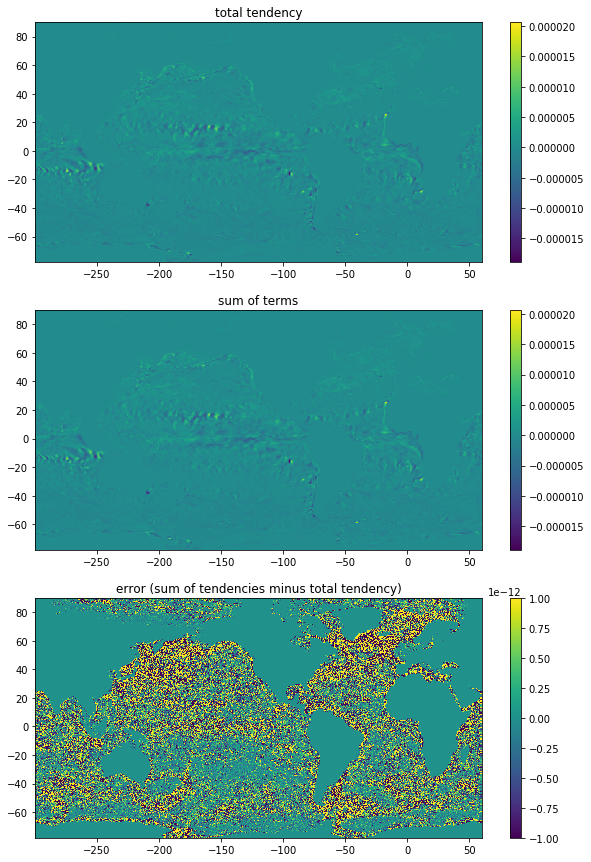

In [41]:
# Oxygen
o2_terms = ['o2_advection_xy','o2h_tendency_vert_remap','o2_dfxy_cont_tendency','o2_vdiffuse_impl','jo2']
tend = 'o2h_tendency'
tend_sum, error = calc_budget(ksum,o2_terms,tend,omit=[],errors=[-1E-12,1E-12])

#### Single profile

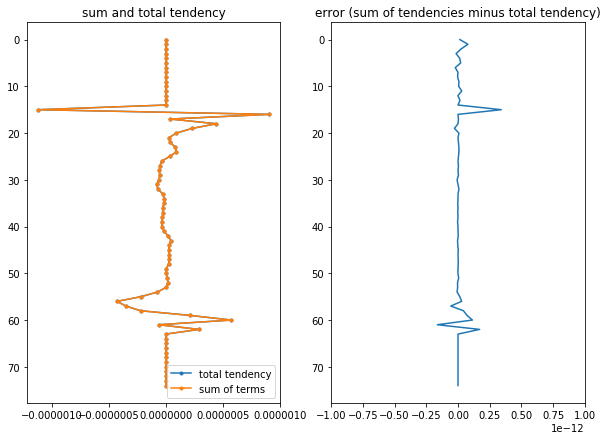

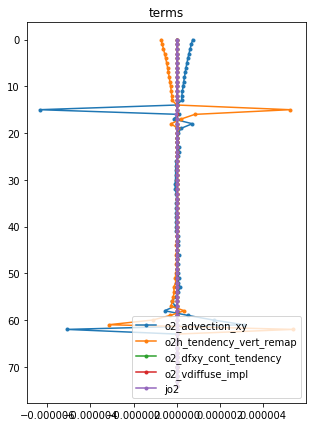

In [42]:
tend_sum, error = calc_budget(prof,o2_terms,tend,omit=[],errors=[-1E-12,1E-12])
plot_budgetterms(prof,o2_terms)

***
### Heat
#### Vertical sum

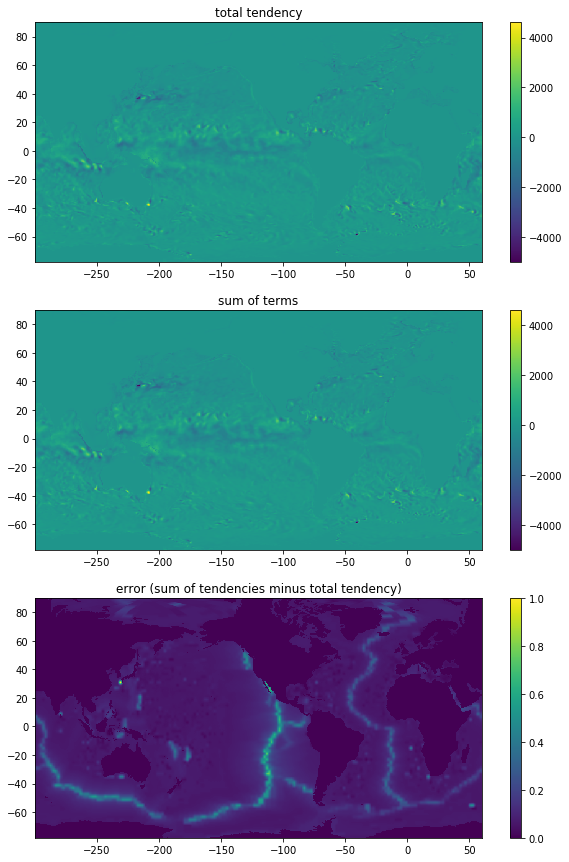

In [43]:
# Heat
heat_terms = ['T_advection_xy','Th_tendency_vert_remap','boundary_forcing_heat_tendency','opottempdiff','opottemppmdiff','frazil_heat_tendency']
tend = 'opottemptend'
tend_sum, error = calc_budget(ksum,heat_terms,tend,errors=[0,1])

#### Geothermal heat (vertical sum and profile)

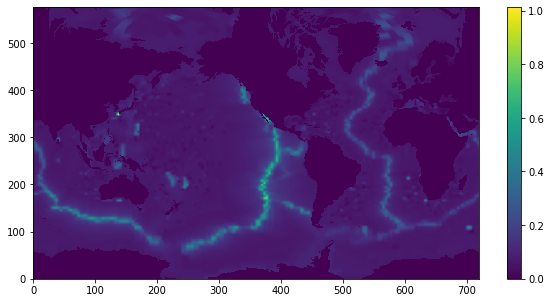

In [44]:
fig,ax=plt.subplots(figsize=(10,5))
im=plt.pcolormesh(ksum.internal_heat)
plt.colorbar(im)

#### Single profile

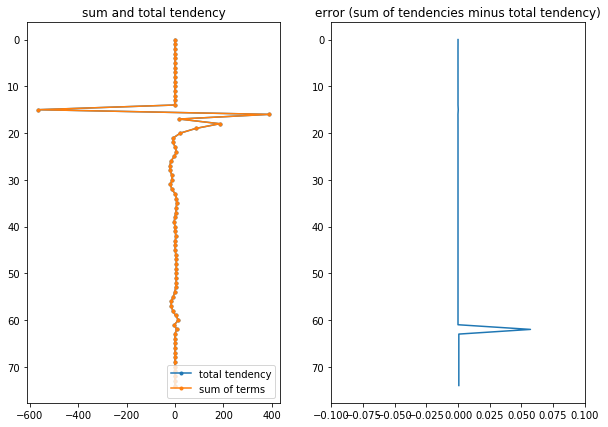

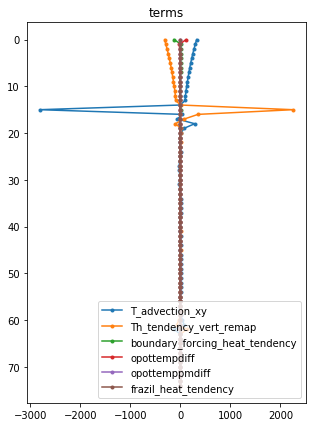

In [45]:
tend_sum, error = calc_budget(prof,heat_terms,tend,omit=[],errors=[-0.1,0.1])
plot_budgetterms(prof,heat_terms)

***
### Salt
#### Vertical sum

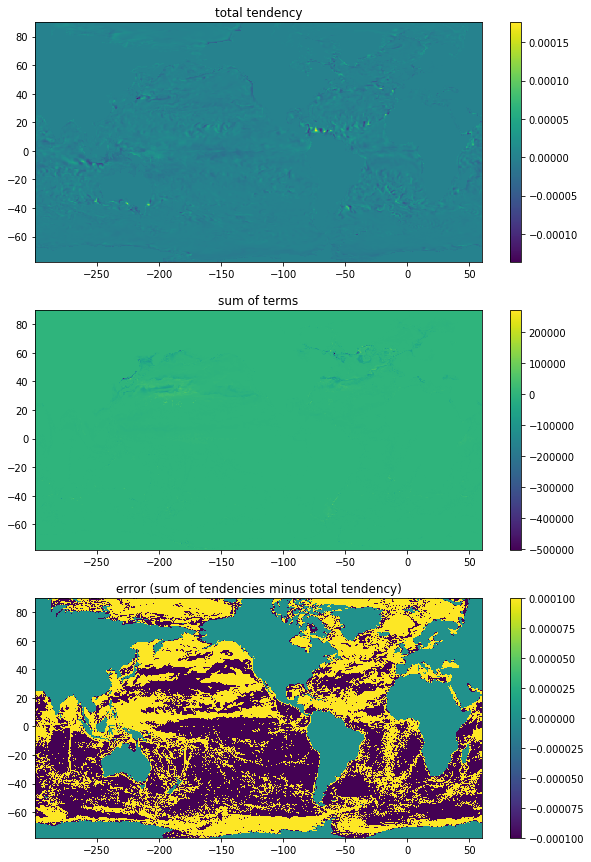

In [53]:
# Salt
salt_terms = ['S_advection_xy','Sh_tendency_vert_remap','boundary_forcing_salt_tendency','osaltdiff','osaltpmdiff']
tend = 'osalttend'
tend_sum, error = calc_budget(ksum,salt_terms,tend,omit=[],errors=[-1E-4,1E-4])

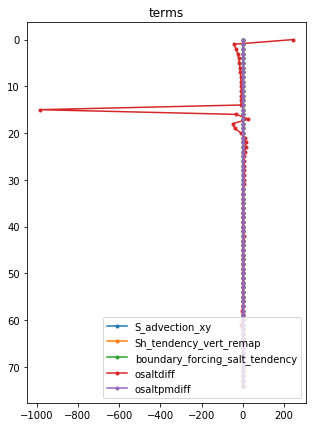

In [54]:
plot_budgetterms(prof,salt_terms)

#### Salt (omitting diabatic diffusion term)

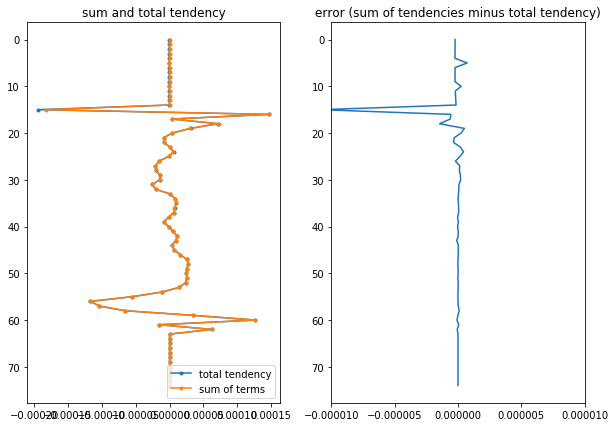

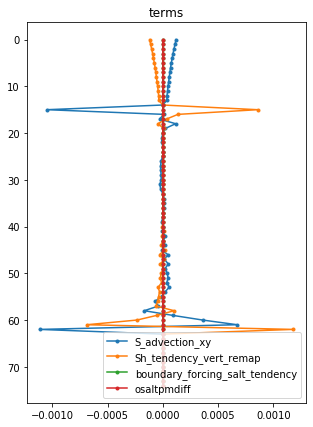

In [57]:
tend_sum, error = calc_budget(prof,salt_terms,tend,omit=['osaltdiff'],errors=[-1E-5,1E-5])
plot_budgetterms(prof,salt_terms,omit=['osaltdiff'])